In [1]:
import warnings
warnings.filterwarnings("ignore")

# FEMA IHP Prediction Model

### Insert Packages

In [2]:
import time
import geopandas
import shapely
import glob
import kaleido
import datetime
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import seaborn as sns
import matplotlib as mpt
from matplotlib import cm
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from scipy.stats import zscore
from sklearn import tree, metrics
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge, ElasticNet, BayesianRidge, LinearRegression, LogisticRegression, RidgeClassifier, LogisticRegressionCV, SGDClassifier, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import train_test_split as tts
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.svm import SVR, LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from yellowbrick.classifier import ConfusionMatrix, ROCAUC, ClassPredictionError, ClassificationReport, PrecisionRecallCurve
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.features import Rank2D, PCA, FeatureImportances
from yellowbrick.model_selection import CVScores, ValidationCurve
from yellowbrick.regressor import ResidualsPlot, PredictionError, AlphaSelection
from yellowbrick.target import ClassBalance

### Data Set Cleaning

In [3]:
# Upload the cleaned fema dataset which shows county-level information. Clean and show the head.
fema_counties = pd.read_csv(r"/Users/victoriawarner/Desktop/FEMA__counties.csv")
del fema_counties['Unnamed: 14']
fema_counties.head(5)

,disasterNumber,fyDeclared,incidentType,declarationTitle,ihProgramDeclared,iaProgramDeclared,paProgramDeclared,hmProgramDeclared,fipsCountyCode,placeCode,designatedArea,declaration_date,incident_begin,incident_end
0,1344,2001,Severe Storm(s),TROPICAL STORM HELENE,0,0,1,1,13,99013,Calhoun (County),11233,11221,11234
1,1344,2001,Severe Storm(s),TROPICAL STORM HELENE,0,0,1,1,5,99005,Bay (County),11233,11221,11234
2,1344,2001,Severe Storm(s),TROPICAL STORM HELENE,0,0,1,1,73,99073,Leon (County),11233,11221,11234
3,1344,2001,Severe Storm(s),TROPICAL STORM HELENE,0,0,1,1,33,99033,Escambia (County),11233,11221,11234
4,1344,2001,Severe Storm(s),TROPICAL STORM HELENE,0,0,1,1,37,99037,Franklin (County),11233,11221,11234


In [4]:
# Determine the shape of this dataframe.
fema_counties.shape

(983, 14)

In [5]:
# Determine the datatypes of each of the features.
fema_counties.dtypes

disasterNumber        int64
fyDeclared            int64
incidentType         object
declarationTitle     object
ihProgramDeclared     int64
iaProgramDeclared     int64
paProgramDeclared     int64
hmProgramDeclared     int64
fipsCountyCode        int64
placeCode             int64
designatedArea       object
declaration_date      int64
incident_begin        int64
incident_end          int64
dtype: object

In [6]:
# Create the disaster length and declaration time variables again within this dataset, as done earlier.
fema_counties['disasterlength']=fema_counties.incident_end-fema_counties.incident_begin
fema_counties['declarationtime']=fema_counties.declaration_date-fema_counties.incident_begin

In [7]:
# Create a dataframe with only certain columns.
fema = pd.DataFrame(fema_counties, columns = ['disasterNumber', 'fyDeclared', 'incidentType',
       'ihProgramDeclared', 'fipsCountyCode', 'declaration_date', 'incident_begin', 'incident_end', 
        'disasterlength', 'declarationtime'])

In [8]:
# Upload the NASA precipitation dataset. View the head.
NASA_clean = pd.read_csv(r"/Users/victoriawarner/Desktop/NASA_cleaned.csv")
NASA_clean.head(5)

,F1,Time,Precip,index_right,County,COUNTYFP,COUNTYNS,GEOID
0,785566,11700,1.377307,46,Hardee,49,295746,12049
1,785567,11700,1.422008,46,Hardee,49,295746,12049
2,785568,11700,2.205662,46,Hardee,49,295746,12049
3,785563,11700,2.647661,46,Hardee,49,295746,12049
4,785564,11700,1.600960,46,Hardee,49,295746,12049


In [9]:
# Make a new dataframe with features needed. Aggregate the precipiation using the sum function.
# Change column names for easier merging and standardization.
NASA_precip = NASA_clean.groupby(['Time','COUNTYFP'], as_index = False).agg({"Precip":"sum"})
NASA_precip.rename(columns={'Time':'date',
                           'COUNTYFP':'fipsCountyCode',
                           'Precip':'precipitation'}, inplace=True)
NASA_precip.head(5)

,date,fipsCountyCode,precipitation
0,11138,1,83.462032
1,11138,3,107.994505
2,11138,5,243.399351
3,11138,7,22.170107
4,11138,9,515.593921


In [10]:
# Merge the FEMA and Nasa Datasets by County and the Incident begin date.
merged_data = pd.merge(fema, NASA_precip, left_on=['fipsCountyCode','incident_begin'], 
                       right_on=['fipsCountyCode', 'date'], how = 'left')
merged_data.head(5)

,disasterNumber,fyDeclared,incidentType,ihProgramDeclared,fipsCountyCode,declaration_date,incident_begin,incident_end,disasterlength,declarationtime,date,precipitation
0,1344,2001,Severe Storm(s),0,13,11233,11221,11234,13,12,11221.0,231.740465
1,1344,2001,Severe Storm(s),0,5,11233,11221,11234,13,12,11221.0,467.422299
2,1344,2001,Severe Storm(s),0,73,11233,11221,11234,13,12,11221.0,191.362700
3,1344,2001,Severe Storm(s),0,33,11233,11221,11234,13,12,11221.0,452.590444
4,1344,2001,Severe Storm(s),0,37,11233,11221,11234,13,12,11221.0,615.414363


In [11]:
# Clean the dataset by dropping NaN values and describe the remaining dataset.
merged_data = merged_data.dropna()
merged_data.describe()

,disasterNumber,fyDeclared,ihProgramDeclared,fipsCountyCode,declaration_date,incident_begin,incident_end,disasterlength,declarationtime,date,precipitation
count,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000,951.000000
mean,2780.050473,2010.176656,0.355415,68.112513,14852.701367,14845.447950,14874.316509,28.868559,7.253417,14845.447950,293.272383
std,1098.963584,6.190682,0.478891,38.680404,2224.780251,2223.932507,2220.168876,16.454997,11.585378,2223.932507,721.242740
min,1344.000000,2001.000000,0.000000,1.000000,11233.000000,11221.000000,11234.000000,0.000000,0.000000,11221.000000,0.000000
25%,1561.000000,2004.000000,0.000000,35.000000,12687.000000,12685.000000,12739.000000,13.000000,2.000000,12685.000000,4.838580
50%,3220.000000,2008.000000,0.000000,69.000000,14115.000000,14109.000000,14134.000000,25.000000,3.000000,14109.000000,53.483596
75%,3419.000000,2017.000000,1.000000,101.000000,17414.000000,17413.000000,17458.000000,44.000000,6.000000,17413.000000,240.130217
max,4468.000000,2020.000000,1.000000,133.000000,18190.000000,18136.000000,18148.000000,70.000000,57.000000,18136.000000,10005.937872


In [12]:
LE = LabelEncoder()
merged_data['disasterType'] = LE.fit_transform(merged_data['incidentType'])

In [13]:
feature_names = ['date','declarationtime','fipsCountyCode','disasterlength','precipitation','disasterType']
X = merged_data[feature_names]
y = merged_data['ihProgramDeclared']

### Feature Selection: Regularization Techniques

In [14]:
model = Lasso()
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

[('date', -3.121154493868493e-05), ('declarationtime', -0.0), ('fipsCountyCode', 0.0), ('disasterlength', 0.005328492757508104), ('precipitation', 2.0062086586769932e-05), ('disasterType', -0.0)]


In [15]:
model = Ridge()
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

[('date', -2.418750481764899e-05), ('declarationtime', -0.001538927261429702), ('fipsCountyCode', 0.0005844395251985717), ('disasterlength', 0.00914369805596764), ('precipitation', 3.664747788825979e-05), ('disasterType', -0.0015826618287494872)]


In [16]:
model = ElasticNet()
model.fit(X, y)
print(list(zip(X, model.coef_.tolist())))

[('date', -2.788535990030095e-05), ('declarationtime', -0.0), ('fipsCountyCode', 0.0002580452159716778), ('disasterlength', 0.007298275400944087), ('precipitation', 2.621705274632359e-05), ('disasterType', -0.0)]


### Feature Selection: Transformer Methods

In [17]:
model = Lasso()
sfm = SelectFromModel(model)
sfm.fit(X,y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['date', 'disasterlength', 'precipitation']


In [18]:
model = Ridge()
sfm = SelectFromModel(model)
sfm.fit(X,y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['disasterlength']


In [19]:
model = ElasticNet()
sfm = SelectFromModel(model)
sfm.fit(X,y)
print(list(X.iloc[:, sfm.get_support(indices=True)]))

['disasterlength']


### Dimensionality Reduction: Principal Component Analysis (PCA)

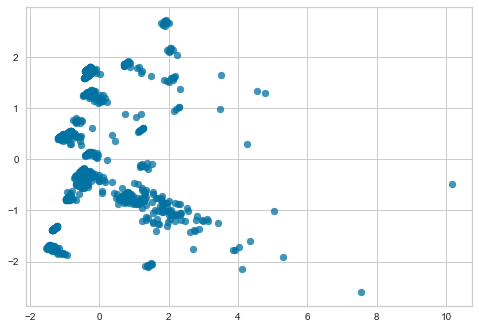

In [20]:
pca = PCA(n_components=2)
new_features = pca.fit(X).transform(X)
plt.savefig('features.png')

### Dimensionality Reduction: Linear Discriminant Analysis (LDA)

In [21]:
lda = LDA()
new_features = lda.fit(X,y).transform(X)
print(new_features)

[[-6.13400050e-01]
 [-5.89201930e-01]
 [-4.08270530e-01]
 [-4.92576997e-01]
 [-4.41853516e-01]
 [-1.49980243e-01]
 [-5.29472111e-01]
 [-6.32480339e-01]
 [-4.48740265e-01]
 [ 2.59953542e-01]
 [-3.76948872e-01]
 [-6.84058782e-01]
 [-7.45030442e-01]
 [-4.72000926e-01]
 [-8.12859436e-01]
 [-1.93934366e-01]
 [-4.09292022e-01]
 [-7.85768808e-01]
 [-5.82017295e-01]
 [-8.67710349e-01]
 [-8.04396471e-01]
 [-8.68752165e-01]
 [-7.10000322e-01]
 [-8.55988867e-01]
 [-9.12768776e-01]
 [-5.58209128e-01]
 [-9.30402625e-01]
 [-5.82050123e-01]
 [-6.02252477e-01]
 [-6.00590255e-01]
 [-9.21960961e-01]
 [-4.61685518e-01]
 [-5.74441515e-01]
 [-5.96565270e-01]
 [ 2.08321870e+00]
 [ 2.28411001e+00]
 [ 2.43325351e+00]
 [ 2.11341692e+00]
 [ 2.38456378e+00]
 [ 2.20292048e+00]
 [ 2.31436493e+00]
 [ 2.18754828e+00]
 [ 2.45561993e+00]
 [ 2.12581906e+00]
 [ 2.06643726e+00]
 [ 2.09568473e-01]
 [-4.72368255e-01]
 [-4.08221194e-01]
 [-1.43530590e-01]
 [ 1.91834322e-02]
 [-2.79332090e-01]
 [-2.25441711e-01]
 [-4.1968859

In [22]:
df = pd.DataFrame(merged_data, columns = ['fyDeclared','declarationtime','disasterlength','precipitation', 'disasterType'])
corrMatrix = df.corr()
print(corrMatrix)

                 fyDeclared  declarationtime  disasterlength  precipitation  \
fyDeclared         1.000000         0.089534       -0.254829      -0.055152   
declarationtime    0.089534         1.000000       -0.167606       0.175678   
disasterlength    -0.254829        -0.167606        1.000000      -0.111412   
precipitation     -0.055152         0.175678       -0.111412       1.000000   
disasterType      -0.141408         0.132562       -0.054649       0.304271   

                 disasterType  
fyDeclared          -0.141408  
declarationtime      0.132562  
disasterlength      -0.054649  
precipitation        0.304271  
disasterType         1.000000  


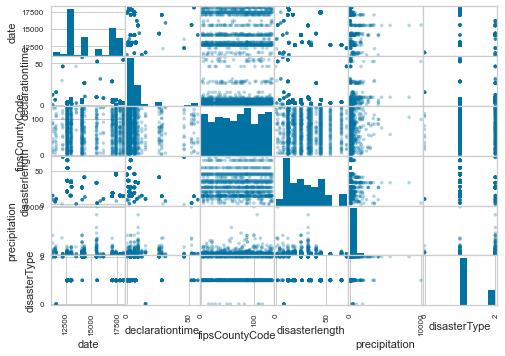

In [23]:
pd.plotting.scatter_matrix(X, alpha=0.3)
plt.savefig("features.png")

In [24]:
# Set the train and test data.
X_train,X_test,y_train,y_test= tts(X,y,test_size=0.20,random_state=0)

<AxesSubplot:title={'center':'Feature Importances of 6 Features using Ridge'}, xlabel='coefficient value'>

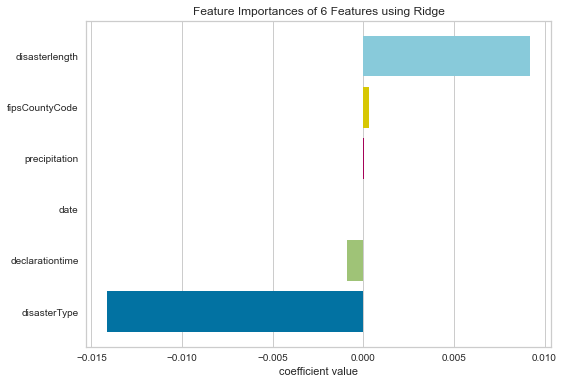

In [25]:
model = FeatureImportances(Ridge(alpha=0.5), relative=False)
model.fit(X_train, y_train)
model.score(X_test, y_test)
model.show(outpath="six_features.png")

<AxesSubplot:title={'center':'Pearson Ranking of 6 Features'}>

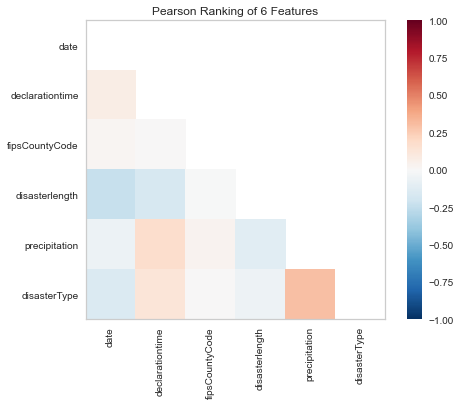

In [26]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show(outpath="pearson.png") # Finalize and render the figure

In [27]:
feature_names = ['disasterType','fipsCountyCode','disasterlength','precipitation']
X = merged_data[feature_names]
y = merged_data['ihProgramDeclared']
X_train,X_test,y_train,y_test= tts(X,y,test_size=0.2,random_state=0)

<AxesSubplot:title={'center':'Feature Importances of 4 Features using Ridge'}, xlabel='coefficient value'>

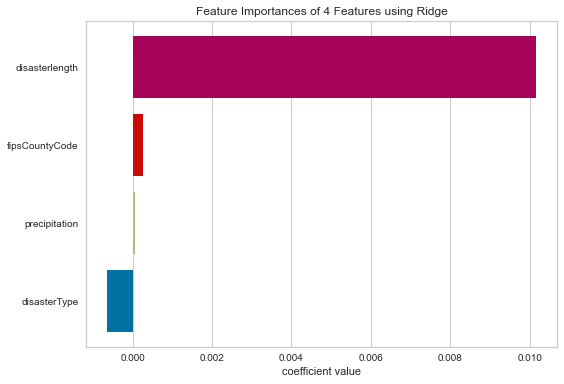

In [28]:
model = FeatureImportances(Ridge(alpha=0.5), relative=False)
model.fit(X_train, y_train)
model.score(X_test, y_test)
model.show(outpath="fourfeatures.png")

<AxesSubplot:title={'center':'Pearson Ranking of 4 Features'}>

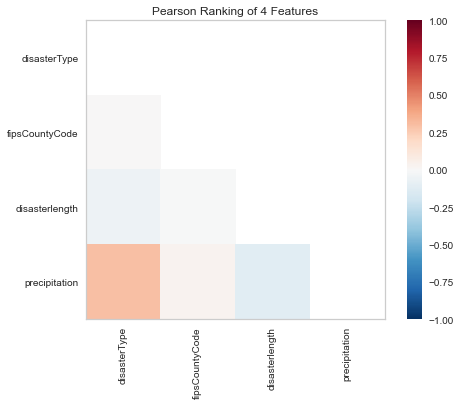

In [29]:
# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')
visualizer.fit(X, y)           # Fit the data to the visualizer
visualizer.transform(X)        # Transform the data
visualizer.show(outpath="pearson.png") # Finalize and render the figure

### Modeling and Evaluation

In [30]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """ 
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted)))

In [31]:
# Try them all!

models = [
    SVC(gamma='auto'), NuSVC(gamma='auto'), LinearSVC(), 
    SGDClassifier(max_iter=100, tol=1e-3), KNeighborsClassifier(), 
    LogisticRegression(solver='lbfgs'), LogisticRegressionCV(cv=3), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100)
]

for model in models:
    score_model(X, y, model)

SVC: 0.0
NuSVC: 0.721461187214612
LinearSVC: 0.919175911251981
SGDClassifier: 0.9220985691573926
KNeighborsClassifier: 0.7332382310984309
LogisticRegression: 0.8341384863123994
LogisticRegressionCV: 0.0
BaggingClassifier: 0.8922610015174507
ExtraTreesClassifier: 0.9235668789808917
RandomForestClassifier: 0.9247648902821317


In [32]:
def plot_classification_report(cr, title='Classification report', cmap=plt.cm.Reds):

    lines = cr.split('\n')
    classes = []
    plotMat = []

    for line in lines[2 : (len(lines) - 5)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)

    fig, ax = plt.subplots(figsize=(10,5))
    fig = plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    
    for c in range(len(plotMat)+1):
        for r in range(len(classes)):
            try:
                txt = plotMat[r][c]
                ax.text(c,r,plotMat[r][c],va='center',ha='center')
            except IndexError:
                pass
            
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes)-1)
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
        
    plt.yticks(y_tick_marks, classes)
   
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [33]:
logreg = LogisticRegression(class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))
expected   = y_test
predicted  = logreg.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Not Declared", "Declared"])
print(classificationReport)

Accuracy of Logistic regression classifier on training set: 0.65
Accuracy of Logistic regression classifier on test set: 0.65
              precision    recall  f1-score   support

Not Declared       0.72      0.71      0.71       119
    Declared       0.53      0.56      0.54        72

    accuracy                           0.65       191
   macro avg       0.63      0.63      0.63       191
weighted avg       0.65      0.65      0.65       191



<AxesSubplot:title={'center':'LogisticRegression Classification Report'}>

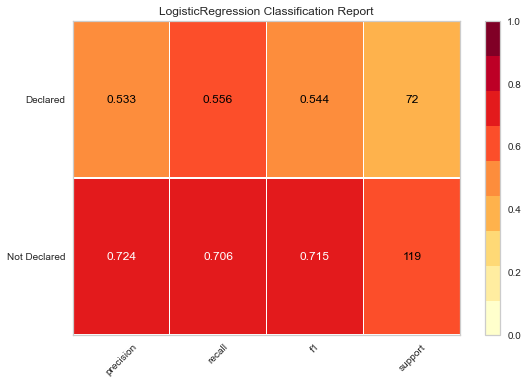

In [34]:
classes = ["Not Declared", "Declared"]
visualizer = ClassificationReport(logreg, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="logisticregression.png")                       # Finalize and show the figure

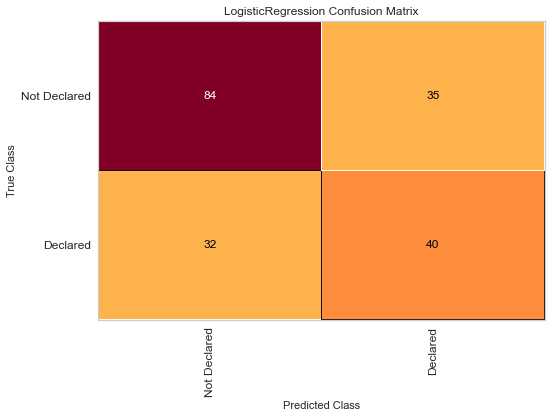

<AxesSubplot:title={'center':'LogisticRegression Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [35]:
cm = ConfusionMatrix(logreg, classes=['Not Declared','Declared'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

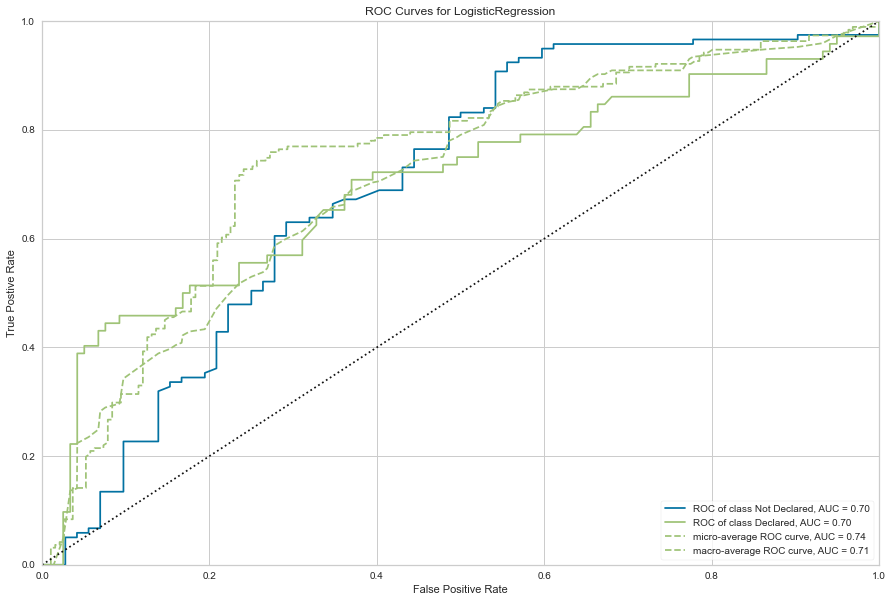

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [36]:
# Instantiate the visualizer with the classification model
classes = ["Not Declared", "Declared"]
visualizer = ROCAUC(LogisticRegression(
    multi_class="auto", solver="liblinear"
    ), classes=classes, size=(1080, 720)
)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

In [37]:
forest = RandomForestClassifier(random_state=0, n_estimators=50)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

expected   = y_test
predicted  = forest.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Not Declared", "Declared"])
print(classificationReport)

Accuracy on training set: 0.963
Accuracy on test set: 0.759
              precision    recall  f1-score   support

Not Declared       0.79      0.83      0.81       119
    Declared       0.70      0.64      0.67        72

    accuracy                           0.76       191
   macro avg       0.74      0.74      0.74       191
weighted avg       0.76      0.76      0.76       191



In [38]:
#Features importance for RandomForest
print("Feature importances:\n{}".format(forest.feature_importances_))

Feature importances:
[0.03384978 0.22224785 0.42560259 0.31829977]


<AxesSubplot:title={'center':'RandomForestClassifier Classification Report'}>

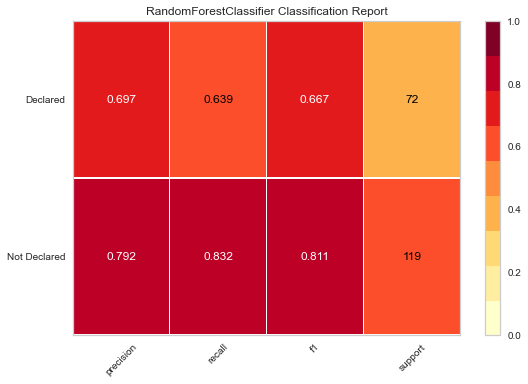

In [39]:
classes = ["Not Declared", "Declared"]
visualizer = ClassificationReport(forest, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="forest.png")                       # Finalize and show the figure

<AxesSubplot:title={'center':'Precision-Recall Curve for RandomForestClassifier'}, xlabel='Recall', ylabel='Precision'>

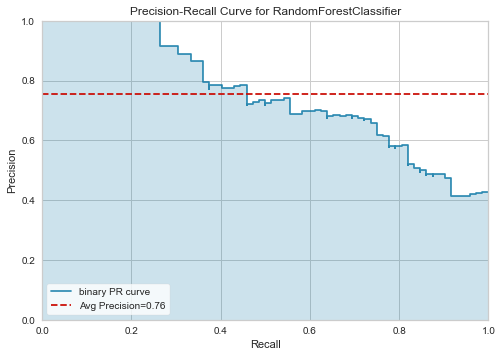

In [40]:
viz = PrecisionRecallCurve(forest)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show(outpath="forest_recallcurve.png")

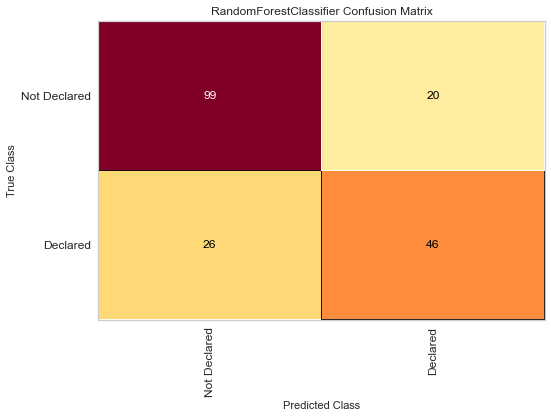

<AxesSubplot:title={'center':'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [41]:
cm = ConfusionMatrix(forest, classes=["Not Declared", "Declared"])
# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)
# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)
# How did we do?
cm.show()

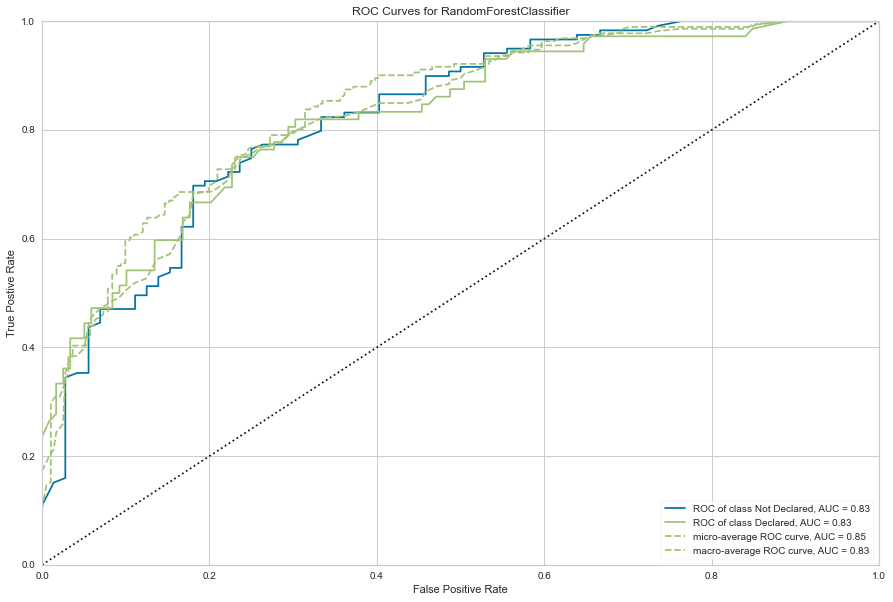

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [42]:
# Instantiate the visualizer with the classification model
classes = ["Not Declared", "Declared"]
visualizer = ROCAUC(RandomForestClassifier(), classes=classes, size=(1080, 720))
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

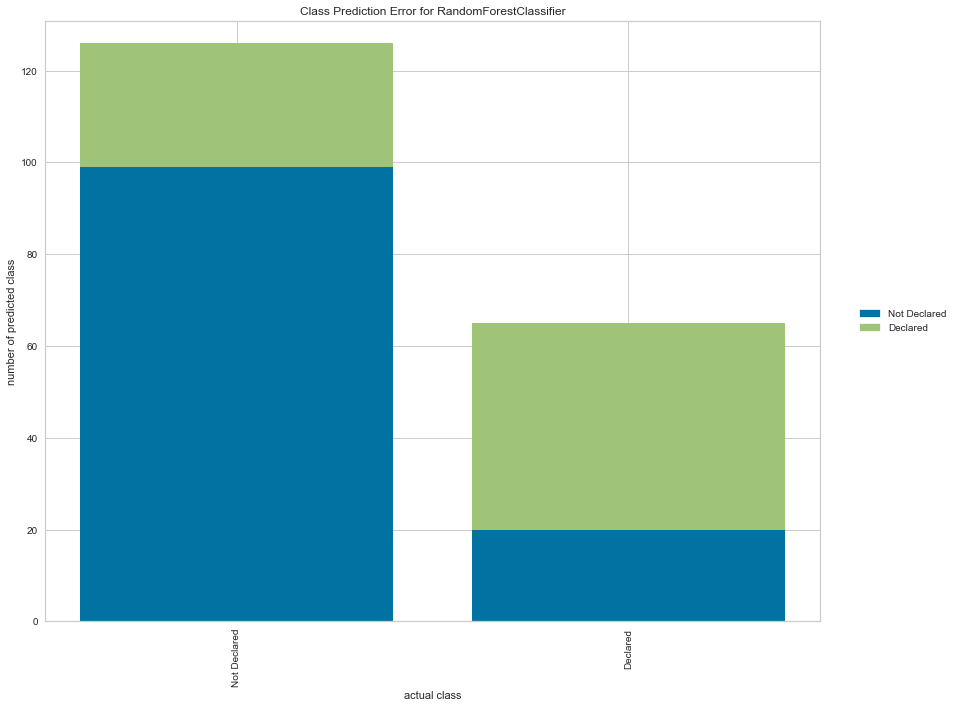

<AxesSubplot:title={'center':'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [43]:
# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    RandomForestClassifier(n_estimators=10), 
    classes=classes, size=(1080, 720))
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
# Evaluate the model on the test data
visualizer.score(X_test, y_test)
# Draw visualization
visualizer.show()

In [44]:
clf = DecisionTreeClassifier(max_depth=30, class_weight="balanced").fit(X_train, y_train)
y_pred=clf.predict(X_test)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

expected   = y_test
predicted  = clf.predict(X_test)
classificationReport = classification_report(expected, predicted, target_names=["Not Declared", "Declared"])
print(classificationReport)

Accuracy of Decision Tree classifier on training set: 0.96
Accuracy of Decision Tree classifier on test set: 0.72
              precision    recall  f1-score   support

Not Declared       0.79      0.75      0.77       119
    Declared       0.62      0.67      0.64        72

    accuracy                           0.72       191
   macro avg       0.70      0.71      0.70       191
weighted avg       0.72      0.72      0.72       191



<AxesSubplot:title={'center':'DecisionTreeClassifier Classification Report'}>

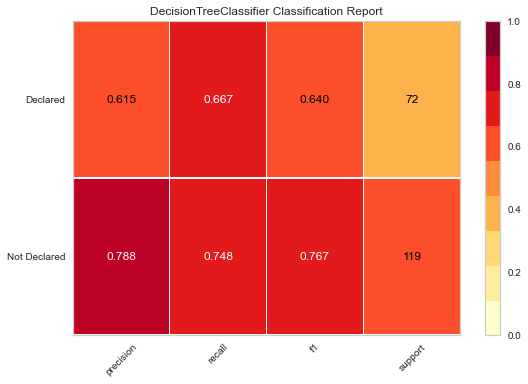

In [45]:
classes = ["Not Declared", "Declared"]
visualizer = ClassificationReport(clf, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show(outpath="decisiontree.png")                       # Finalize and show the figure

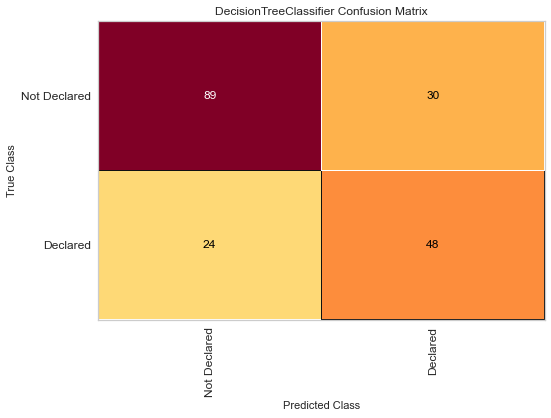

<AxesSubplot:title={'center':'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [46]:
cm = ConfusionMatrix(clf, classes=['Not Declared','Declared'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.show()

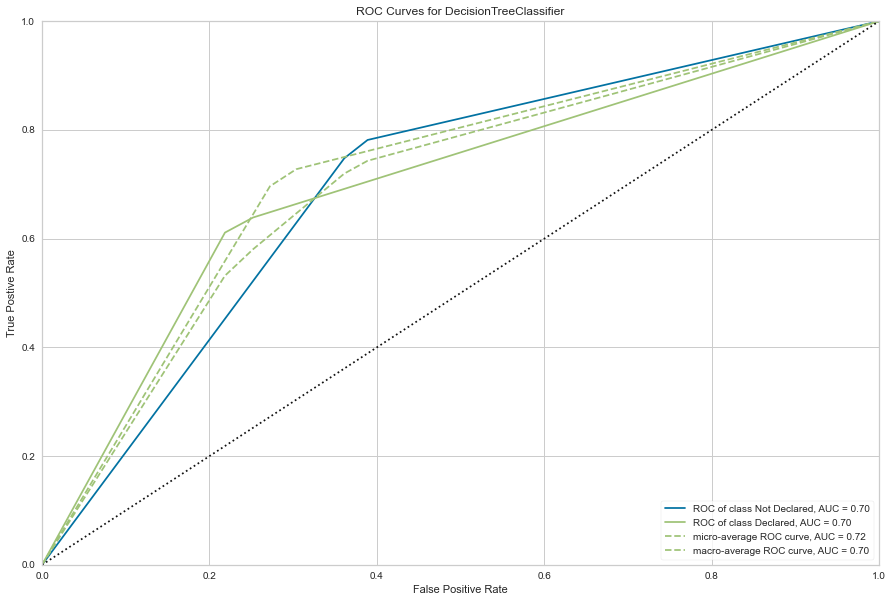

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Postive Rate'>

In [47]:
# Instantiate the visualizer with the classification model
classes = ["Not Declared", "Declared"]
visualizer = ROCAUC(DecisionTreeClassifier(
    ), classes=classes, size=(1080, 720)
)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()   

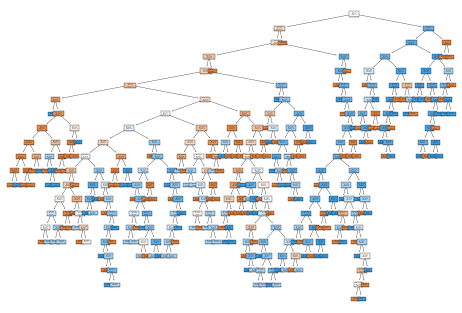

In [48]:
fig = plt.figure()
_ = tree.plot_tree(clf, 
                   filled=True);
fig.savefig("decision_tree.png")

In [49]:
clf = HistGradientBoostingClassifier().fit(X,y)
clf.score(X,y)

0.9400630914826499

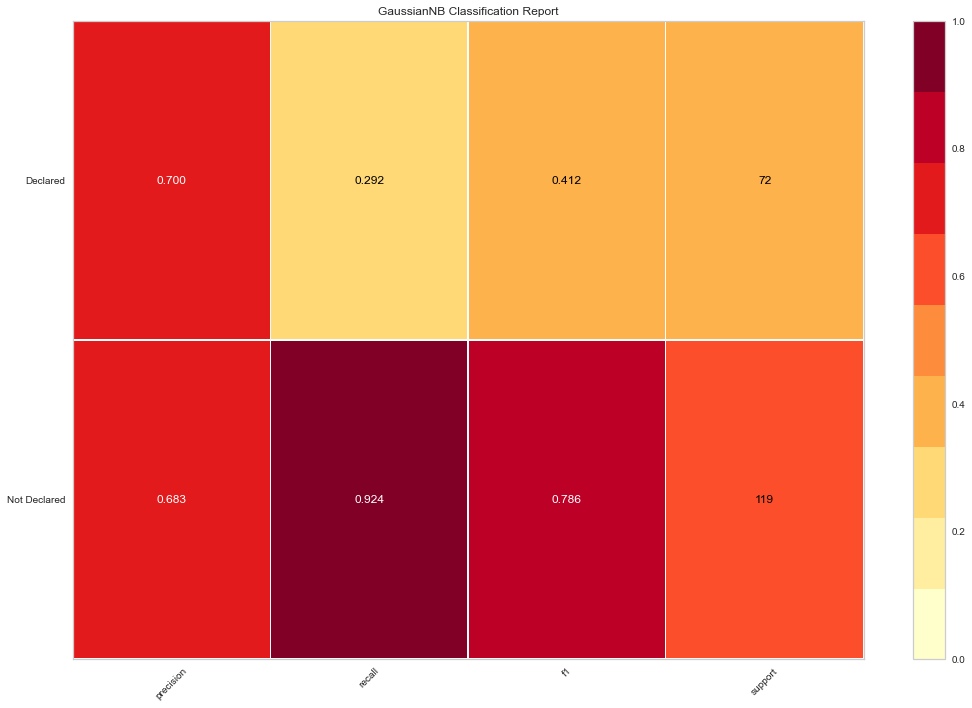

<AxesSubplot:title={'center':'GaussianNB Classification Report'}>

In [50]:
# Instantiate the classification model and visualizer
bayes = GaussianNB()
visualizer = ClassificationReport(
    bayes, classes=classes, support=True, size=(1080, 720)
)

visualizer.fit(X_train, y_train)  # Fit the visualizer and the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

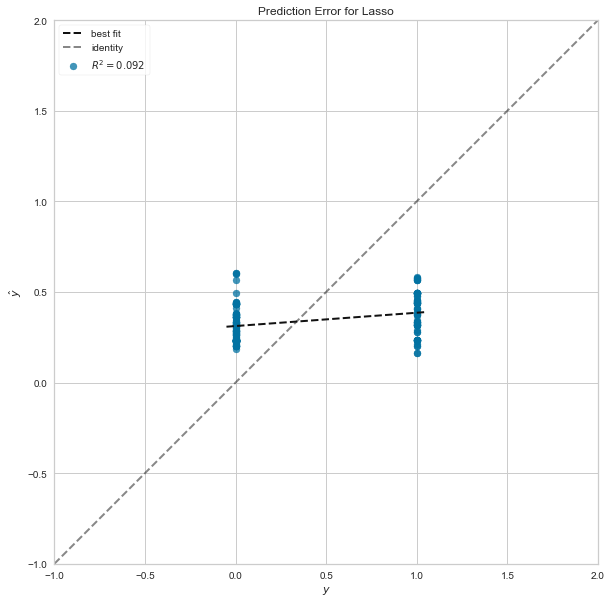

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [51]:
model = Lasso()
visualizer = PredictionError(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

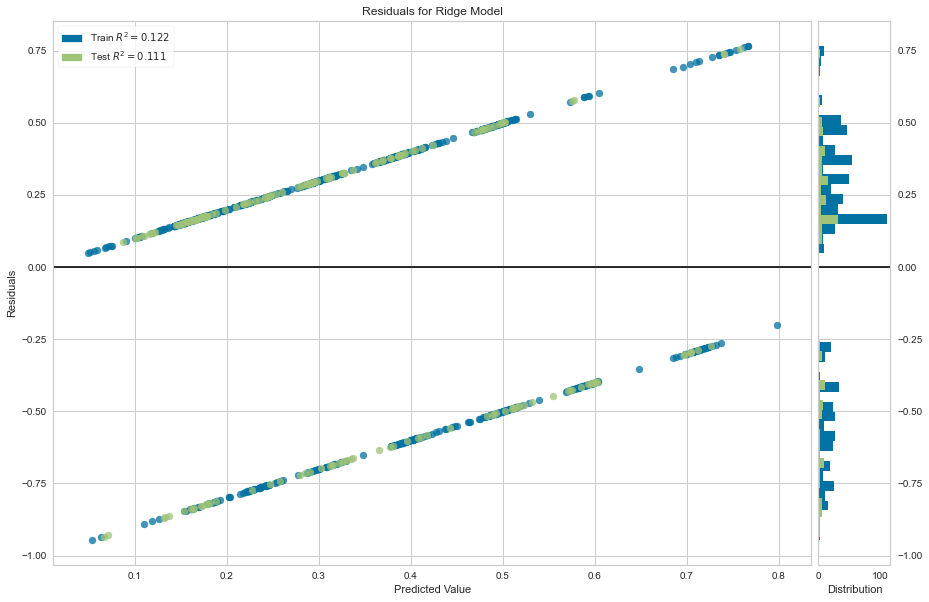

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [52]:
# Instantiate the linear model and visualizer
model = Ridge()
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

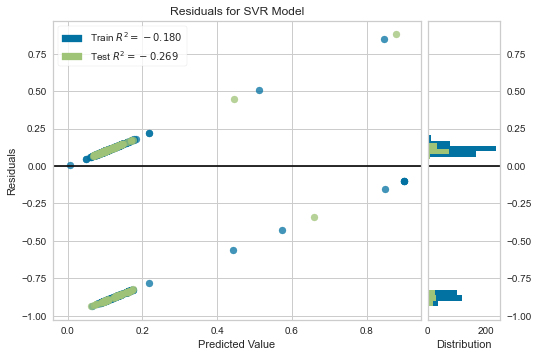

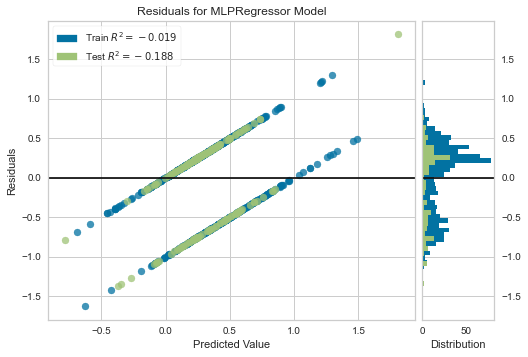

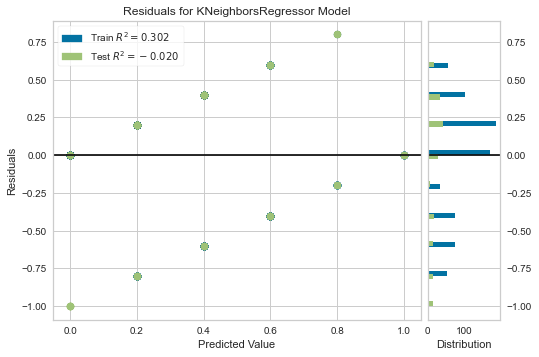

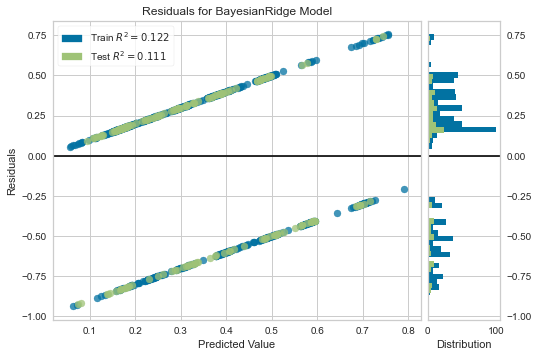

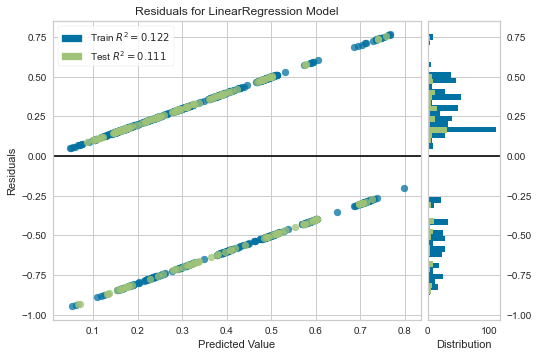

In [53]:
regressors = {
    "support vector machine": SVR(),
    "multilayer perceptron": MLPRegressor(),
    "nearest neighbors": KNeighborsRegressor(),
    "bayesian ridge": BayesianRidge(),
    "linear regression": LinearRegression(),
}

for _, regressor in regressors.items():
    visualizer = ResidualsPlot(regressor)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

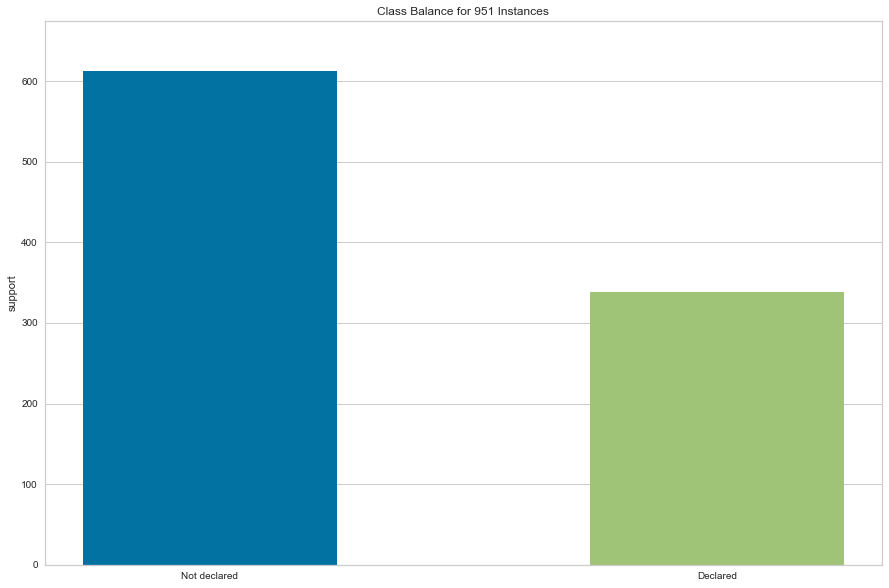

<AxesSubplot:title={'center':'Class Balance for 951 Instances'}, ylabel='support'>

In [54]:
visualizer = ClassBalance(labels=["Not declared","Declared"], size=(1080, 720))
visualizer.fit(y)
visualizer.show()

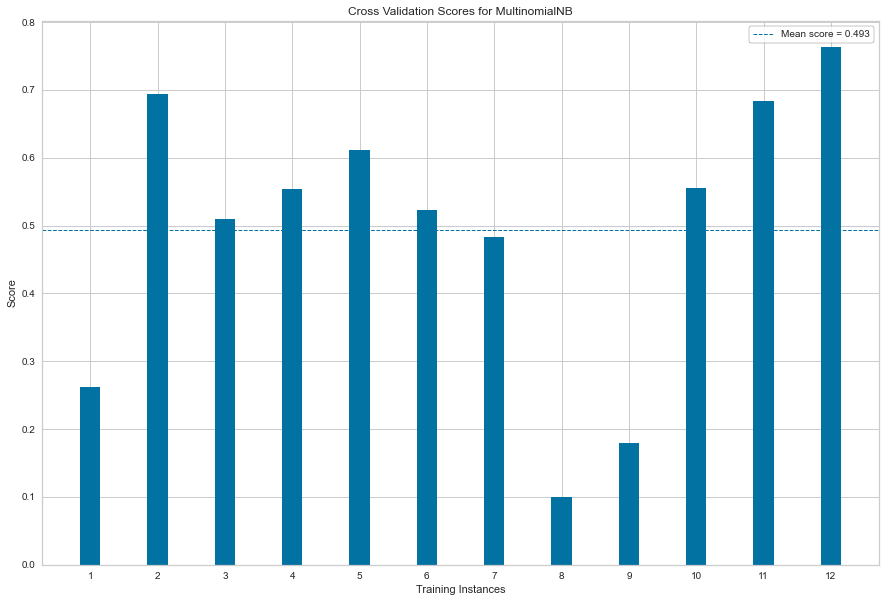

<AxesSubplot:title={'center':'Cross Validation Scores for MultinomialNB'}, xlabel='Training Instances', ylabel='Score'>

In [55]:
# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = MultinomialNB()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(1080, 720)
)

visualizer.fit(X, y)
visualizer.show()

In [56]:
model = Ridge(random_state=0)

alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
tuned_params = [{'alpha': alphas}]
n_folds = 5

grid = GridSearchCV(model, tuned_params, cv=n_folds)

grid.fit(X, y)
print(grid.best_estimator_)

Ridge(alpha=1000, random_state=0)


In [57]:
# Use GridSearchCV to see whether we need to tune any of the Ridge parameters.
model = Ridge(random_state=0)

# Create a dictionary with the Ridge parameter options
# We will explicitly tune our possible `solver` so that "auto" is not returned.
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'fit_intercept':[True,False], 
              'normalize':[True,False], 'copy_X':[True, False], 'solver':['svd', 'cholesky', 'lsqr', 'sparse_cg']}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X, y)

print(clf.best_estimator_)

Ridge(alpha=1000, fit_intercept=False, normalize=True, random_state=0,
      solver='lsqr')


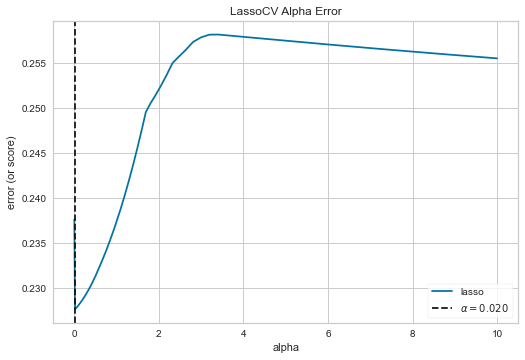

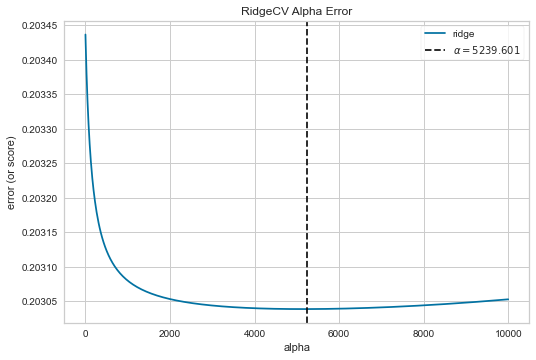

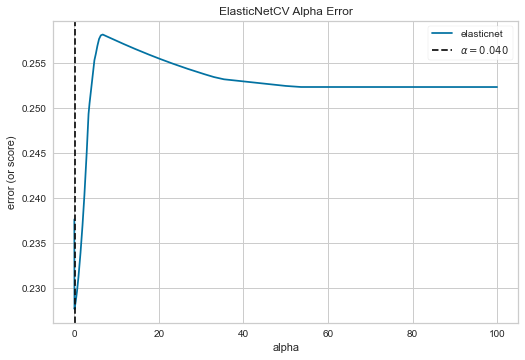

In [58]:
# Create some lists of alphas to cross-validate against
small_range = np.logspace(-10, 1, 400)
medium_range = np.logspace(-10, 2, 400)
large_range = np.logspace(-10, 4, 400)

smoothers = {
    "Lasso": LassoCV(cv=5, alphas=small_range),
    "Ridge": RidgeCV(store_cv_values=True, alphas=large_range),
    "ElasticNet": ElasticNetCV(cv=5, alphas=medium_range)
}

for _, smoother in smoothers.items():
    _, ax = plt.subplots() # Create a new figure
    visualizer = AlphaSelection(smoother, size=(600, 400))
    visualizer.fit(X, y)
    visualizer.show(outpath="alphaerror.png")

<AxesSubplot:title={'center':'Validation Curve for DecisionTreeRegressor'}, xlabel='max_depth', ylabel='score'>

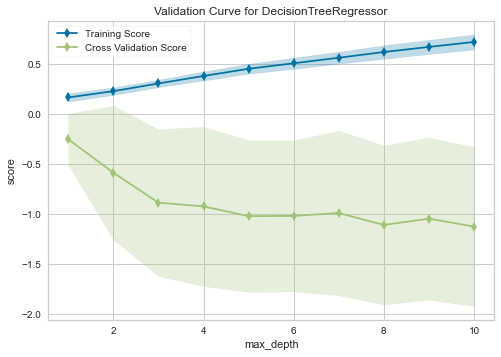

In [59]:
viz = ValidationCurve(
    DecisionTreeRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show(outpath="valcurve-tree.png")

<AxesSubplot:title={'center':'Validation Curve for RandomForestRegressor'}, xlabel='max_depth', ylabel='score'>

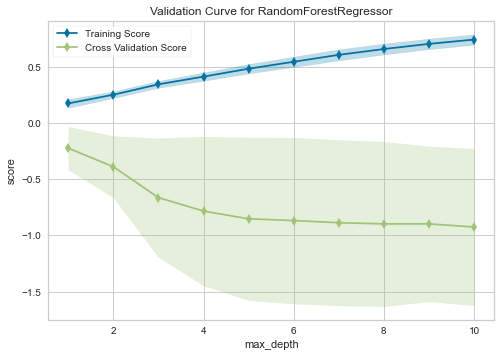

In [60]:
viz = ValidationCurve(
    RandomForestRegressor(), param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="r2"
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show(outpath="valcurve-forest.png")